## Final Project Submission

Please fill out:
* Student name: Terry Thompson
* Student pace: part time
* Scheduled project review date/time: 
* Instructor name: Matt Carr
* Blog post URL:https://www.blogger.com/blog/post/edit/394033909374120085/5566861248363402941


# <div align="center"><b> King County Housing Data </b></div>

#### I will be looking at ways for homeowners to increase their property value in King County, Washington.  Below we will look at the King County Washington housing dataset to build a model that will ascertain which aspects of property improvement would be the best choices for homeowners.  

In [1]:
# Import necessary tools, take a look at the data.
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import scipy.stats as stats
import numpy as np
import pandas as pd
pd.read_csv('kc_house_data.csv')
df = pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [2]:
#check dataset shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [3]:
# Check for NaNs
for column in df.columns:
    num_of_nan = (sum(df[column].isnull()) / len(df[column])) * 100
    print(column, num_of_nan)

id 0.0
date 0.0
price 0.0
bedrooms 0.0
bathrooms 0.0
sqft_living 0.0
sqft_lot 0.0
floors 0.0
waterfront 11.00152798999861
view 0.29170718155299347
condition 0.0
grade 0.0
sqft_above 0.0
sqft_basement 0.0
yr_built 0.0
yr_renovated 17.78950780200954
zipcode 0.0
lat 0.0
long 0.0
sqft_living15 0.0
sqft_lot15 0.0


###### Since the goal of this assessment is to evaluate areas for improvements of property value, we will be getting rid of categories that do not pertain to improving the properties.

In [4]:
df = df.drop(['lat', 'long', 'yr_renovated', 'sqft_living15', 'sqft_lot15', 'date', 'id', 'waterfront', 'view'], axis = 1)

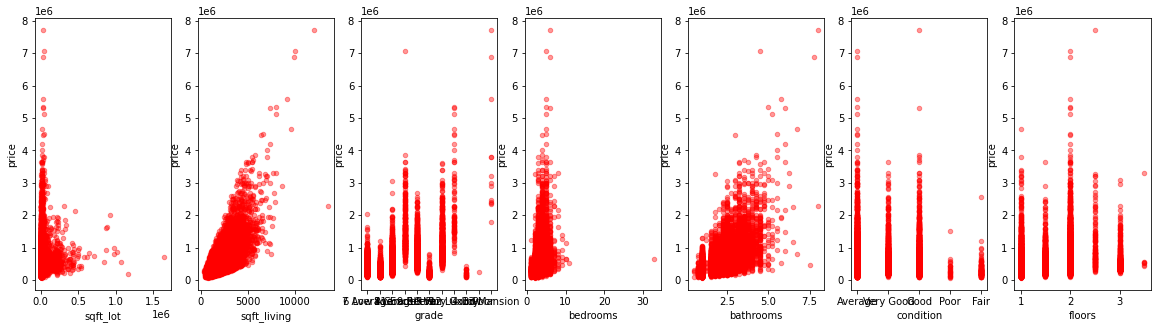

In [5]:
fig, axes = plt.subplots(nrows = 1, ncols = 7, figsize = (20,5))
for xcol, ax in zip(['sqft_lot', 'sqft_living', 'grade', 'bedrooms', 'bathrooms', 'condition', 'floors'], axes):
    df.plot(kind = 'scatter', x = xcol, y = 'price', ax = ax, alpha = 0.4, color = 'r')

###### Grade and condition will need to be cleaned up, as they are not legible.  We will also order them so we can make sense of the charts from hereout.

In [6]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,zipcode
0,221900.0,3,1.00,1180,5650,1.0,Average,7 Average,1180,0.0,1955,98178
1,538000.0,3,2.25,2570,7242,2.0,Average,7 Average,2170,400.0,1951,98125
2,180000.0,2,1.00,770,10000,1.0,Average,6 Low Average,770,0.0,1933,98028
3,604000.0,4,3.00,1960,5000,1.0,Very Good,7 Average,1050,910.0,1965,98136
4,510000.0,3,2.00,1680,8080,1.0,Average,8 Good,1680,0.0,1987,98074


###### The columns "grade" and "condition" both use non-numerical information.  This will need to be converted.

In [7]:
df['condition'] = df['condition'].replace(['Poor', 'Fair', 'Average', 'Good', 'Very Good'], ['1', '2', '3', '4', '5']).astype('int')

In [8]:
grade_list = df['grade'].unique()
print(grade_list)

['7 Average' '6 Low Average' '8 Good' '11 Excellent' '9 Better' '5 Fair'
 '10 Very Good' '12 Luxury' '4 Low' '3 Poor' '13 Mansion']


In [9]:
df['grade'] = df['grade'].replace(['3 Poor', '4 Low', '5 Fair', '6 Low Average', '7 Average',
                                   '8 Good', '9 Better', '10 Very Good', '11 Excellent', '12 Luxury', '13 Mansion'],
                                  ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']).astype('int')

In [10]:
grade_list = df['grade'].unique()
print(grade_list)

[ 5  4  6  9  7  3  8 10  2  1 11]


In [11]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,zipcode
0,221900.0,3,1.00,1180,5650,1.0,3,5,1180,0.0,1955,98178
1,538000.0,3,2.25,2570,7242,2.0,3,5,2170,400.0,1951,98125
2,180000.0,2,1.00,770,10000,1.0,3,4,770,0.0,1933,98028
3,604000.0,4,3.00,1960,5000,1.0,5,5,1050,910.0,1965,98136
4,510000.0,3,2.00,1680,8080,1.0,3,6,1680,0.0,1987,98074


###### Now that the values have been converted to numerals, they need to be ordered.

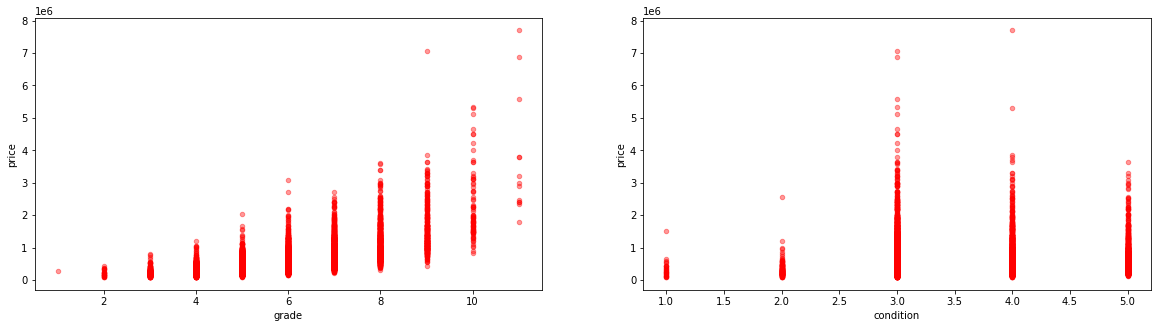

In [12]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20,5))
for xcol, ax in zip(['grade', 'condition'], axes):
    df.plot(kind = 'scatter', x = xcol, y = 'price', ax = ax, alpha = 0.4, color = 'r')

###### Now that grade and condition are arranged in a manner that makes sense, we see that a condition of Average to Good yield better prices than that of Very Good condtitions.  We will investigate this further.

C:\Users\Terry Thompson\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


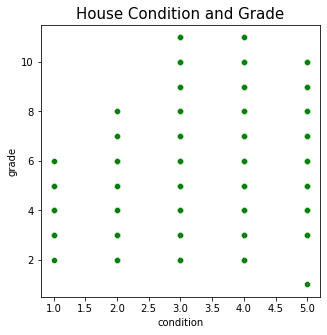

In [13]:
plt.figure(figsize = (5,5))
sns.scatterplot(df['condition'], df['grade'], color = 'g')
plt.title('House Condition and Grade', fontsize = 15);

###### Here we see that the "Average" and "Good" conditions extend into the highest grades.  

C:\Users\Terry Thompson\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


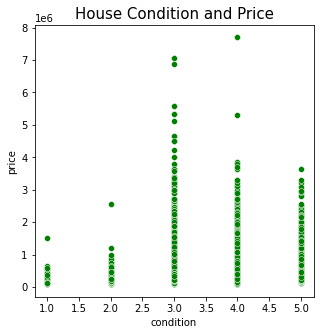

In [14]:
plt.figure(figsize=(5,5))
sns.scatterplot(df['condition'], df['price'], color = 'g')
plt.title('House Condition and Price', fontsize=15);

###### Here we see that houses in the Average to Good conditions fetch a higher price than other conditions.

In [15]:
#One hot encode condition.
ohe = pd.get_dummies(df['condition'], drop_first = True)
df = df.drop('condition',axis = 1)
df = df.join(ohe)

<Figure size 432x288 with 0 Axes>

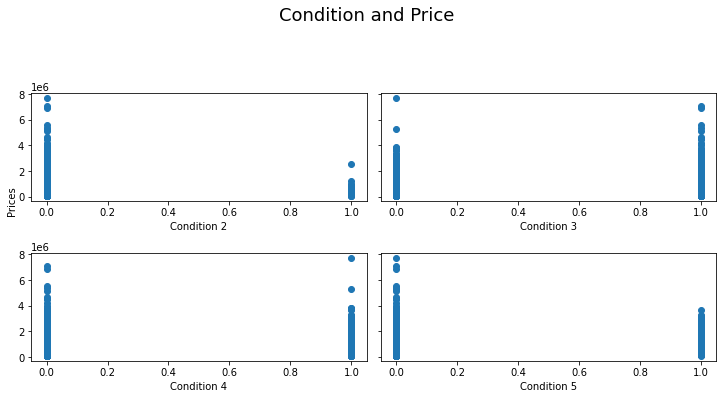

In [16]:
price = df['price']
two = df['two'] = df[2] 
three = df['three'] = df[3] 
four = df['four'] = df[4] 
five = df['five'] = df[5] 

cond_price = plt.figure()
cond_price, axes = plt.subplots(nrows = 2, ncols = 2, sharex=False, sharey = True, figsize=(10,5))

plt.suptitle('Condition and Price', fontsize=18, y=1.1)
cond_price.text(0.0001, 0.56, 'Prices', va='center', rotation='vertical', fontsize=10)

sc = axes[0][0].scatter(two, price)
axes[0][0].set_xlabel('Condition 2')

axes[0][1].scatter(three, price)
axes[0][1].set_xlabel('Condition 3')

axes[1][0].scatter(four, price)
axes[1][0].set_xlabel('Condition 4')

axes[1][1].scatter(five, price)
axes[1][1].set_xlabel('Condition 5')


cond_price.tight_layout()
plt.show()

###### After performing one hot encoding and dropping the "Poor" condition, we see that condition and price have linear relationships.   

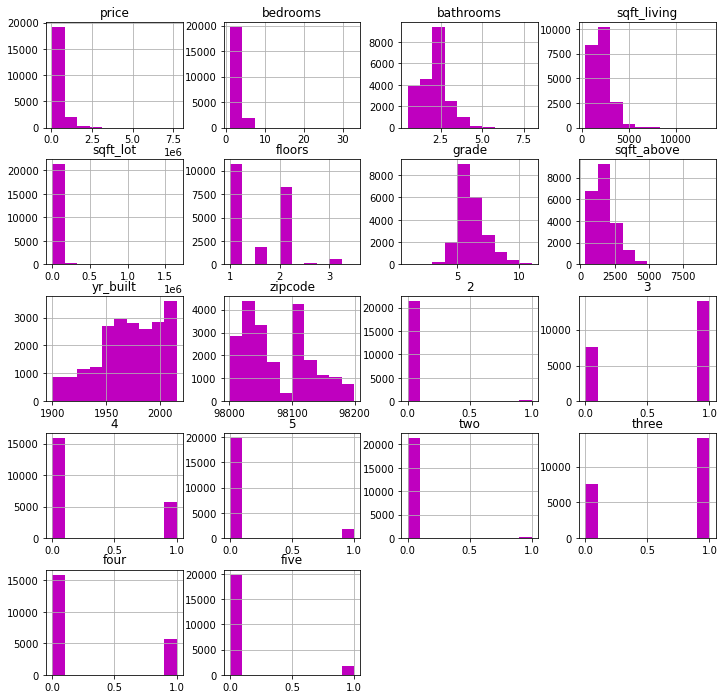

In [17]:
import warnings
warnings.filterwarnings('ignore')
fig = plt.figure(figsize = (12,12))
ax = fig.gca()
df.hist(ax = ax, color = 'm');

###### To avoid using multifamily information in our assessment, we will need to remove outliers from the bedrooms and bathrooms categories.

In [18]:
# Check for outliers and drop outliers
count = 0
outliers = []
mean = np.mean(df['bathrooms'])
max = np.std(df['bathrooms']) * 3
for idx, row in df['bathrooms'].iteritems():
    if abs(row - mean) >= max:
        count += 1
        df.drop(idx, inplace = True)
count

187

In [19]:
count = 0
bed_outliers = []
mean = np.mean(df['bedrooms'])
max_distance = np.std(df['bedrooms']) * 3 

for idx, row in df['bedrooms'].iteritems():
    if abs(row-mean) >= max_distance:
        count += 1
        df.drop(idx,inplace=True)
count

47

###### We have now removed 187 units with bathrooms that were outside of 3 standard deviations, as well as 62 units from bedrooms.

In [20]:
df = df[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'grade', 'sqft_above', 2, 3, 4, 5]]
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,2,3,4,5
0,221900.0,3,1.00,1180,5650,1.0,5,1180,0,1,0,0
1,538000.0,3,2.25,2570,7242,2.0,5,2170,0,1,0,0
2,180000.0,2,1.00,770,10000,1.0,4,770,0,1,0,0
3,604000.0,4,3.00,1960,5000,1.0,5,1050,0,0,0,1
4,510000.0,3,2.00,1680,8080,1.0,6,1680,0,1,0,0


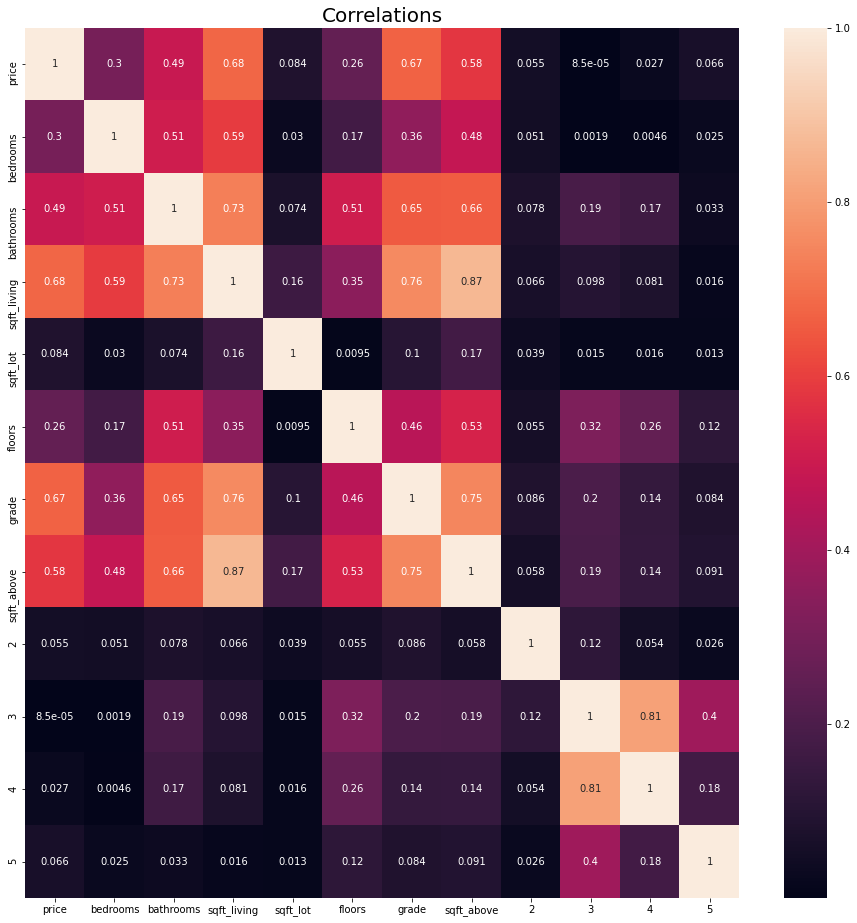

In [21]:
corr = df.corr().abs()
fig, ax = plt.subplots(figsize = (16,16))
plt.title('Correlations', fontsize = 20, y = 1)
heatmap = sns.heatmap(corr, annot = True)
heatmap;

In [22]:
features = []
correlations = []
for idx, correlation in corr['price'].iteritems():
    if correlation >= .30 and idx != 'price':
        features.append(idx)
        correlations.append(correlation)
corr_price_df = pd.DataFrame({'Correlations':correlations, 'Features': features}).sort_values(['Correlations'],
                                                                                              ascending = False)

In [23]:
multico_features = []
multico_corr = []
def check_multico(feature):
    for idx, correlation in corr[feature].iteritems():
        if correlation >= .80 and idx != feature:
            multico_features.append([feature, idx])
            multico_corr.append(correlation)

print('Correlations with Price')
display(corr_price_df)

Correlations with Price


,Correlations,Features
2,0.677596,sqft_living
3,0.668335,grade
4,0.578363,sqft_above
1,0.489138,bathrooms
0,0.302105,bedrooms


In [24]:
for feature in corr:
    check_multico(feature)
multi_df = pd.DataFrame({'Correlations':multico_corr, 'Features': multico_features}).sort_values(['Correlations'],
                                                                                                 ascending = False)
print('Multicollinear Features')
display(multi_df)

Multicollinear Features


,Correlations,Features
0,0.866887,"[sqft_living, sqft_above]"
1,0.866887,"[sqft_above, sqft_living]"
2,0.812117,"[3, 4]"
3,0.812117,"[4, 3]"


###### As we can see from the data above, sqft_living and sqft_above are highly correlated, as well as 3 and 4.  We will drop sqft_above to avoid multicollinearity.  We will keep 3 and 4, as they do not create multicollinearity, as they provide insight into which improvements will be the best.

In [25]:
price = df['price']
bed = df['bedrooms']
bath = df['bathrooms']
sqft_living = df['sqft_living']
sqft_lot = df['sqft_lot']
floors = df['floors']
grade = df['grade']

<Figure size 432x288 with 0 Axes>

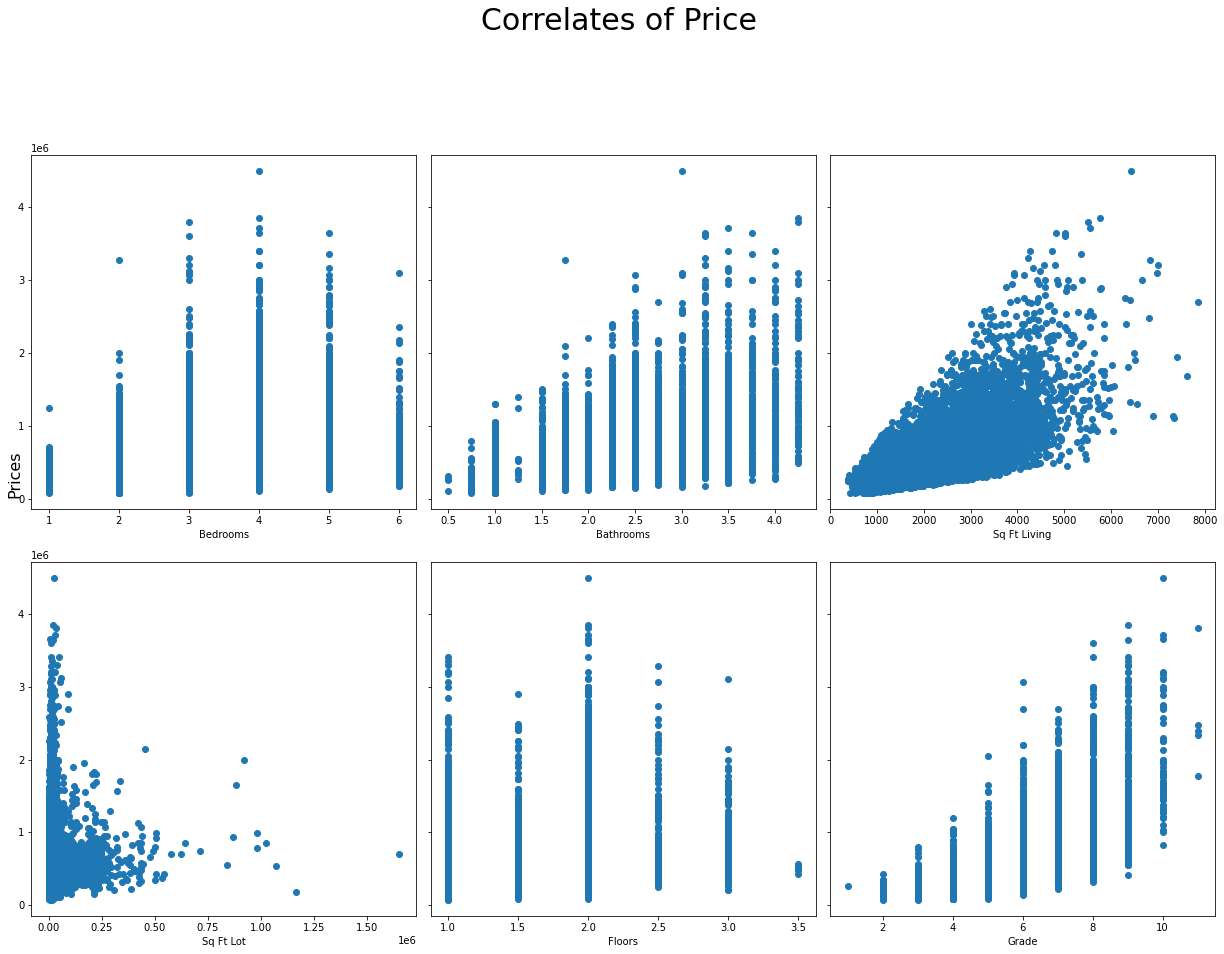

In [26]:
correl = plt.figure()
correl, axes = plt.subplots(nrows = 2, ncols = 3, sharex=False, sharey = True, figsize = (17,12))

correl.suptitle('Correlates of Price', fontsize = 30, y = 1.1)
correl.text(0.0001, 0.56, 'Prices', va = 'center', rotation = 'vertical', fontsize = 16)

axes[0][0].scatter(bed, price)
axes[0][0].set_xlabel('Bedrooms')

axes[0][1].scatter(bath, price)
axes[0][1].set_xlabel('Bathrooms')

axes[0][2].scatter(sqft_living, price)
axes[0][2].set_xlabel('Sq Ft Living')

axes[1][0].scatter(sqft_lot, price)
axes[1][0].set_xlabel('Sq Ft Lot')

axes[1][1].scatter(floors, price)
axes[1][1].set_xlabel('Floors')

axes[1][2].scatter(grade, price)
axes[1][2].set_xlabel('Grade')

correl.tight_layout()
plt.show()

In [27]:
def model_template(model, X, x_name, y):
    
    residuals = model.resid
    
    mod = plt.figure()
    mod, axes = plt.subplots(nrows = 1, ncols = 3, sharex = False, sharey = False, figsize = (65,20), squeeze = False)
       
    mod.text(s = 'Residuals', x = .45, y = .93, fontsize = 60)
    
    sm.graphics.qqplot(residuals, dist = stats.norm, line = '45', fit = True, ax = axes[0][0])    
    plt.show;
    
    mod.text(s = 'QQ Plot', x = .20, y = .93, fontsize = 60)
    
    axes[0][1].hist(residuals)
    plt.show;
    
    sns.residplot(X, y, ax = axes[0][2])
 
    mod.text(s = 'Residuals vs {x}'.format(x = x_name), x = .73, y = .93, fontsize = 60)
    
    mod.text(s = "r-Squared: {r}".format(r = round(model.rsquared, 2)), x = .40, y = 1.05, fontsize = 50)
    
    plt.tight_layout;
    plt.show;

<Figure size 432x288 with 0 Axes>

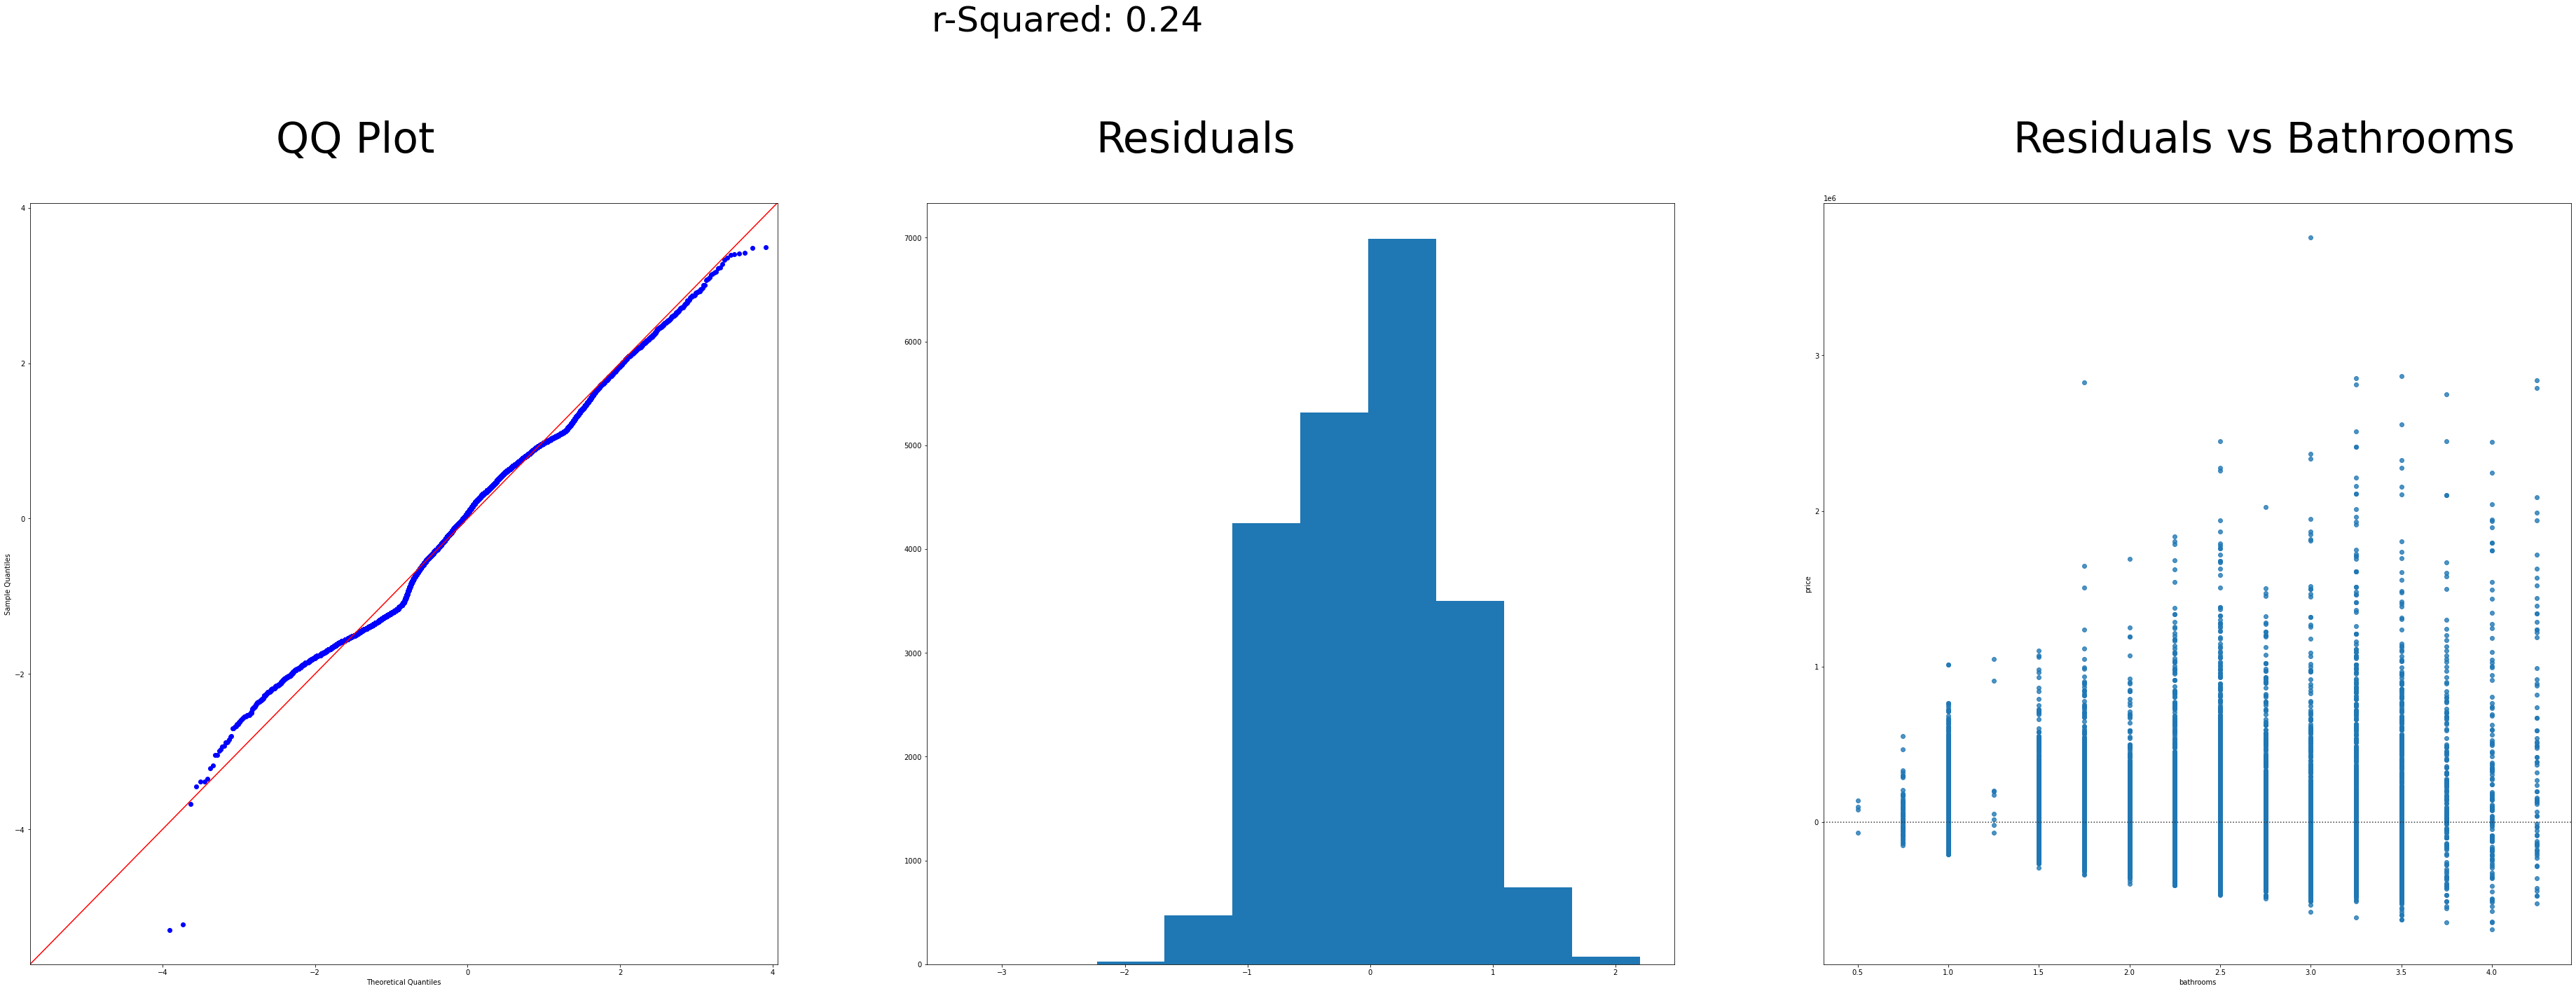

In [28]:
formula = 'bathrooms ~ price'
bath_model = smf.ols(formula=formula, data=df).fit()
model_template(bath_model, bath, 'Bathrooms', price)

<Figure size 432x288 with 0 Axes>

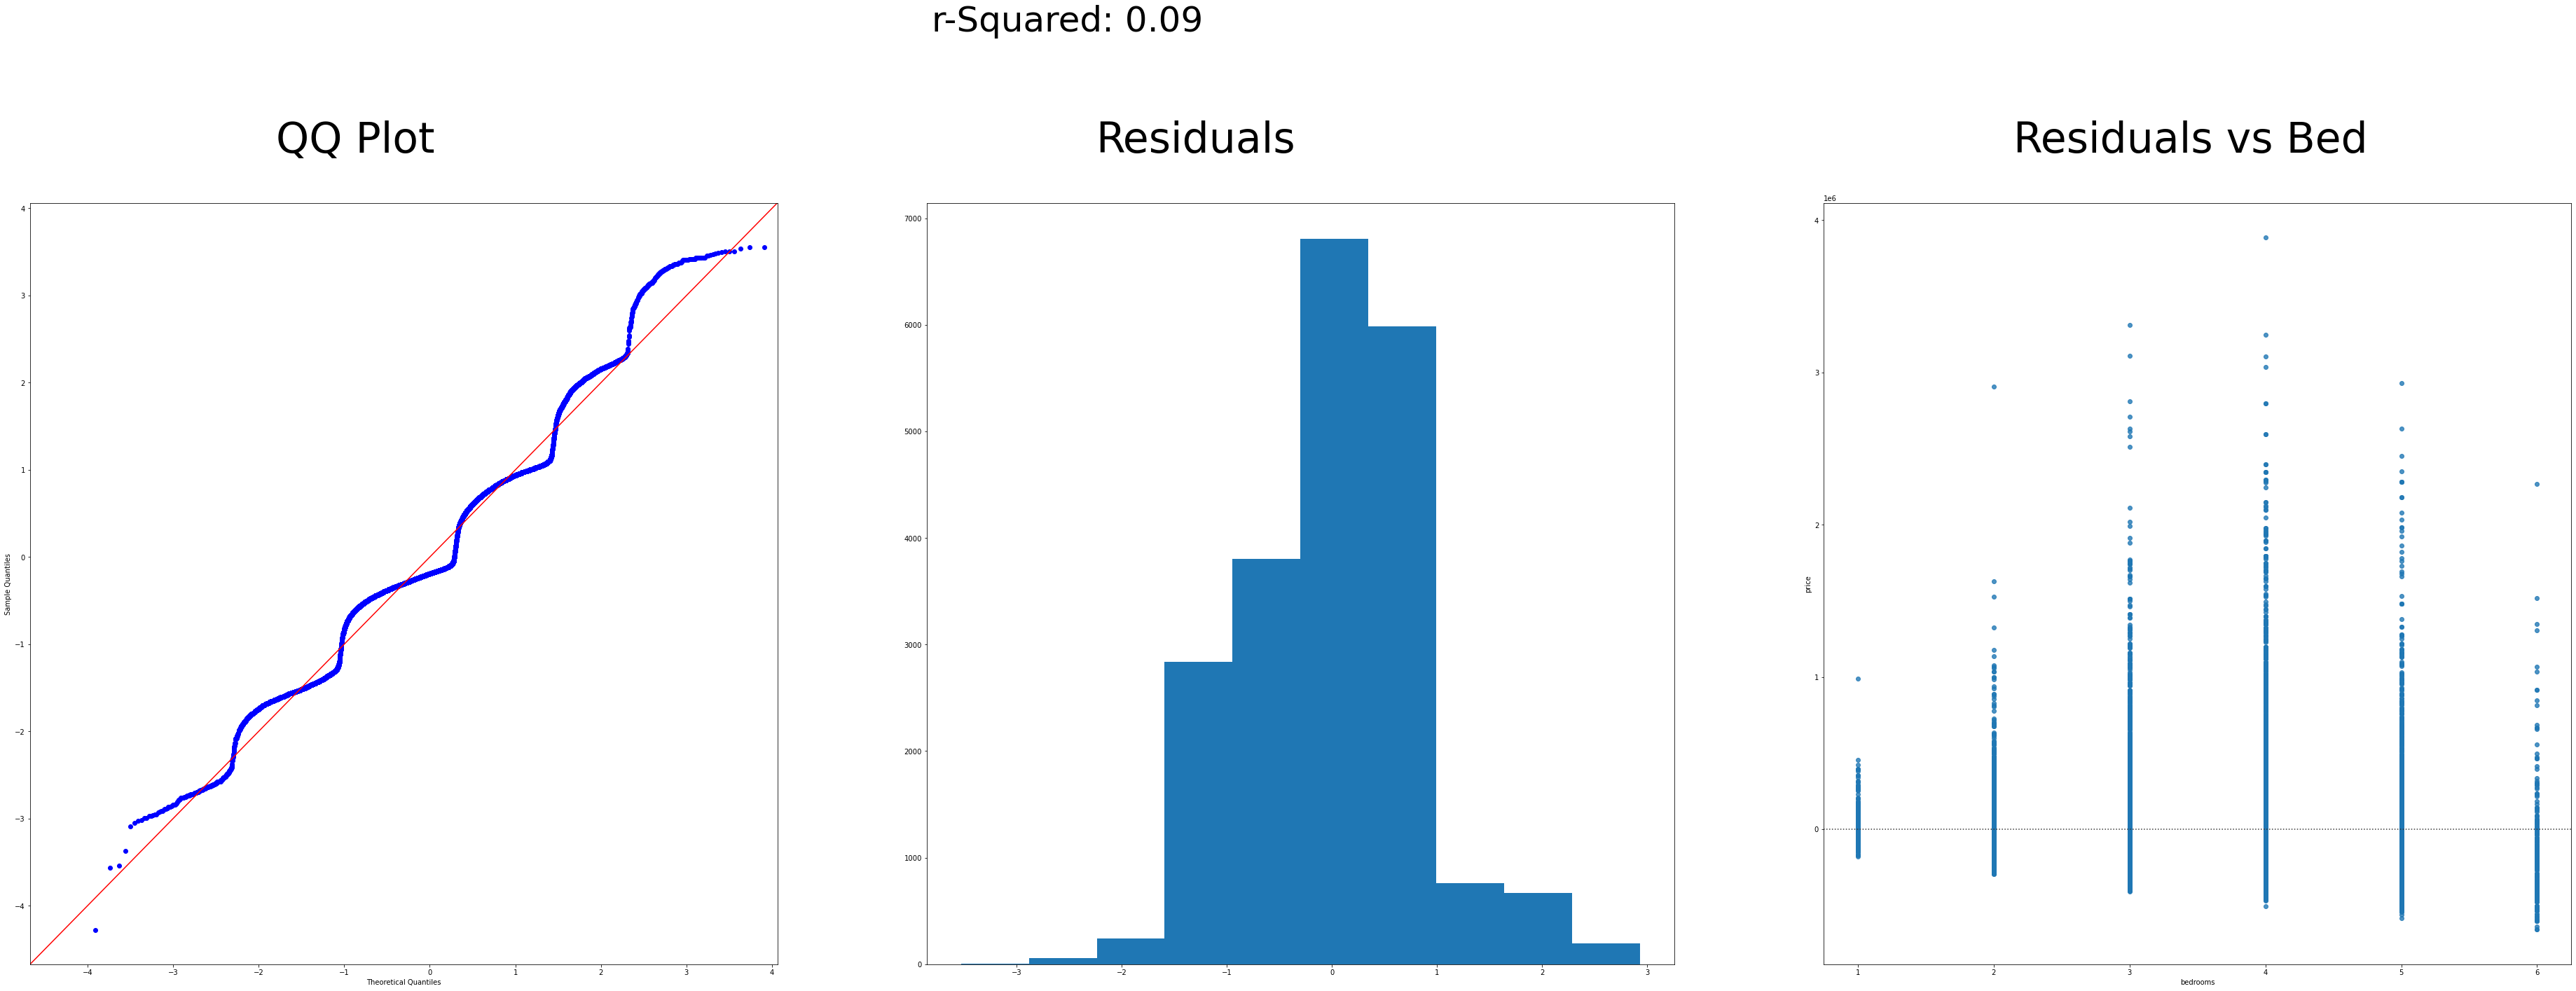

In [29]:
formula = 'bedrooms ~ price'
bed_model = smf.ols(formula=formula, data=df).fit()
model_template(bed_model, bed, 'Bed', price)

<Figure size 432x288 with 0 Axes>

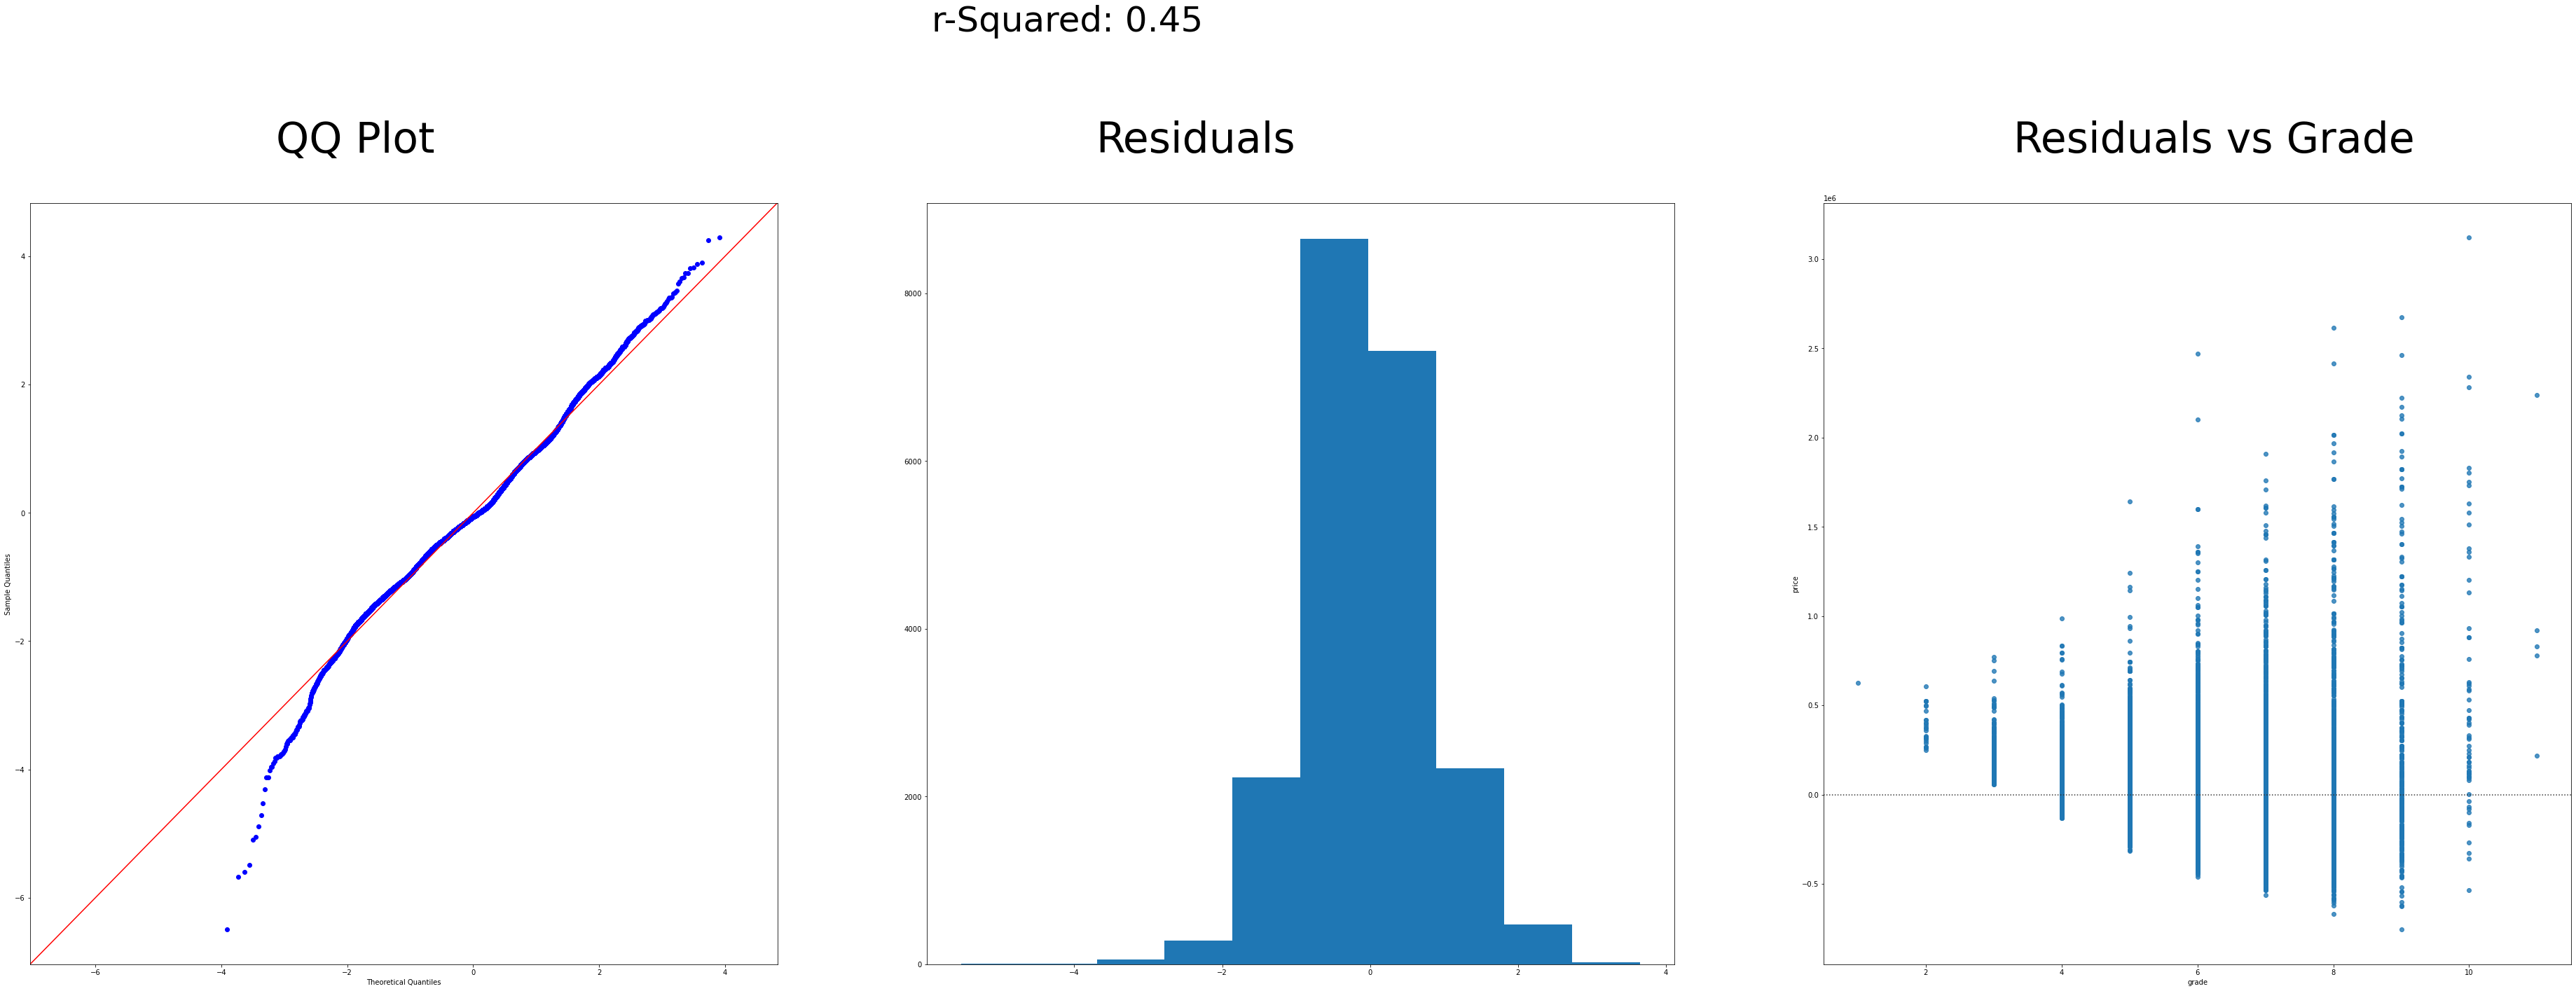

In [30]:
formula = 'grade ~ price'
grade_model = smf.ols(formula=formula, data=df).fit()
model_template(grade_model, grade, 'Grade', price)

<Figure size 432x288 with 0 Axes>

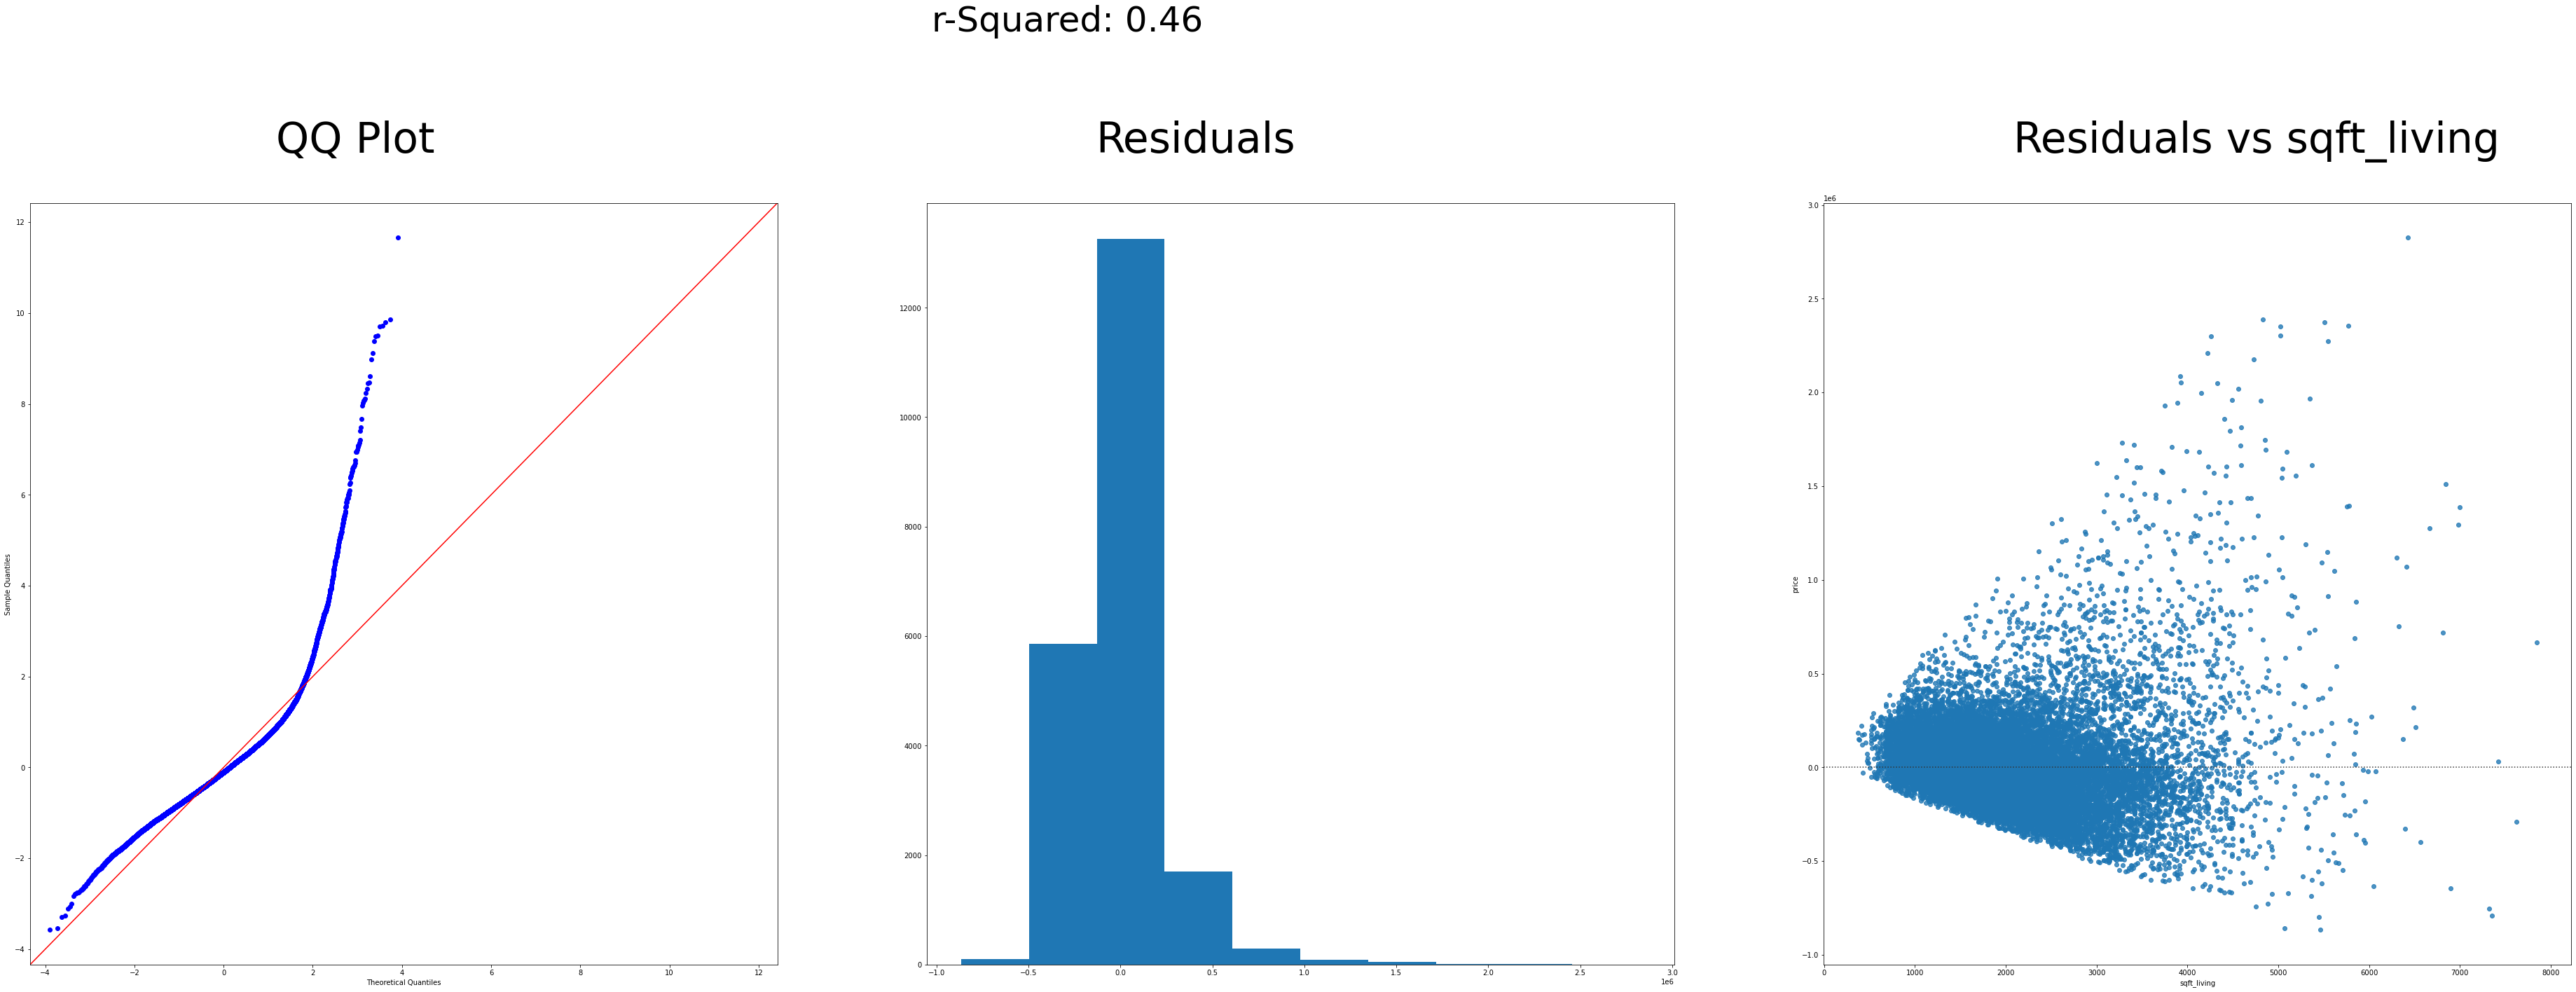

In [31]:
formula = 'price ~ sqft_living'
sqft_liv_model = smf.ols(formula = formula, data = df).fit()
model_template(sqft_liv_model, sqft_living, 'sqft_living', price)

###### Here we can see that the above data violates homoscedascity.  We will need to manipulate the data further to create our model.

In [32]:
df['price'] = np.log(df['price'])
df['sqft_living'] = np.log(df['sqft_living'])

<Figure size 432x288 with 0 Axes>

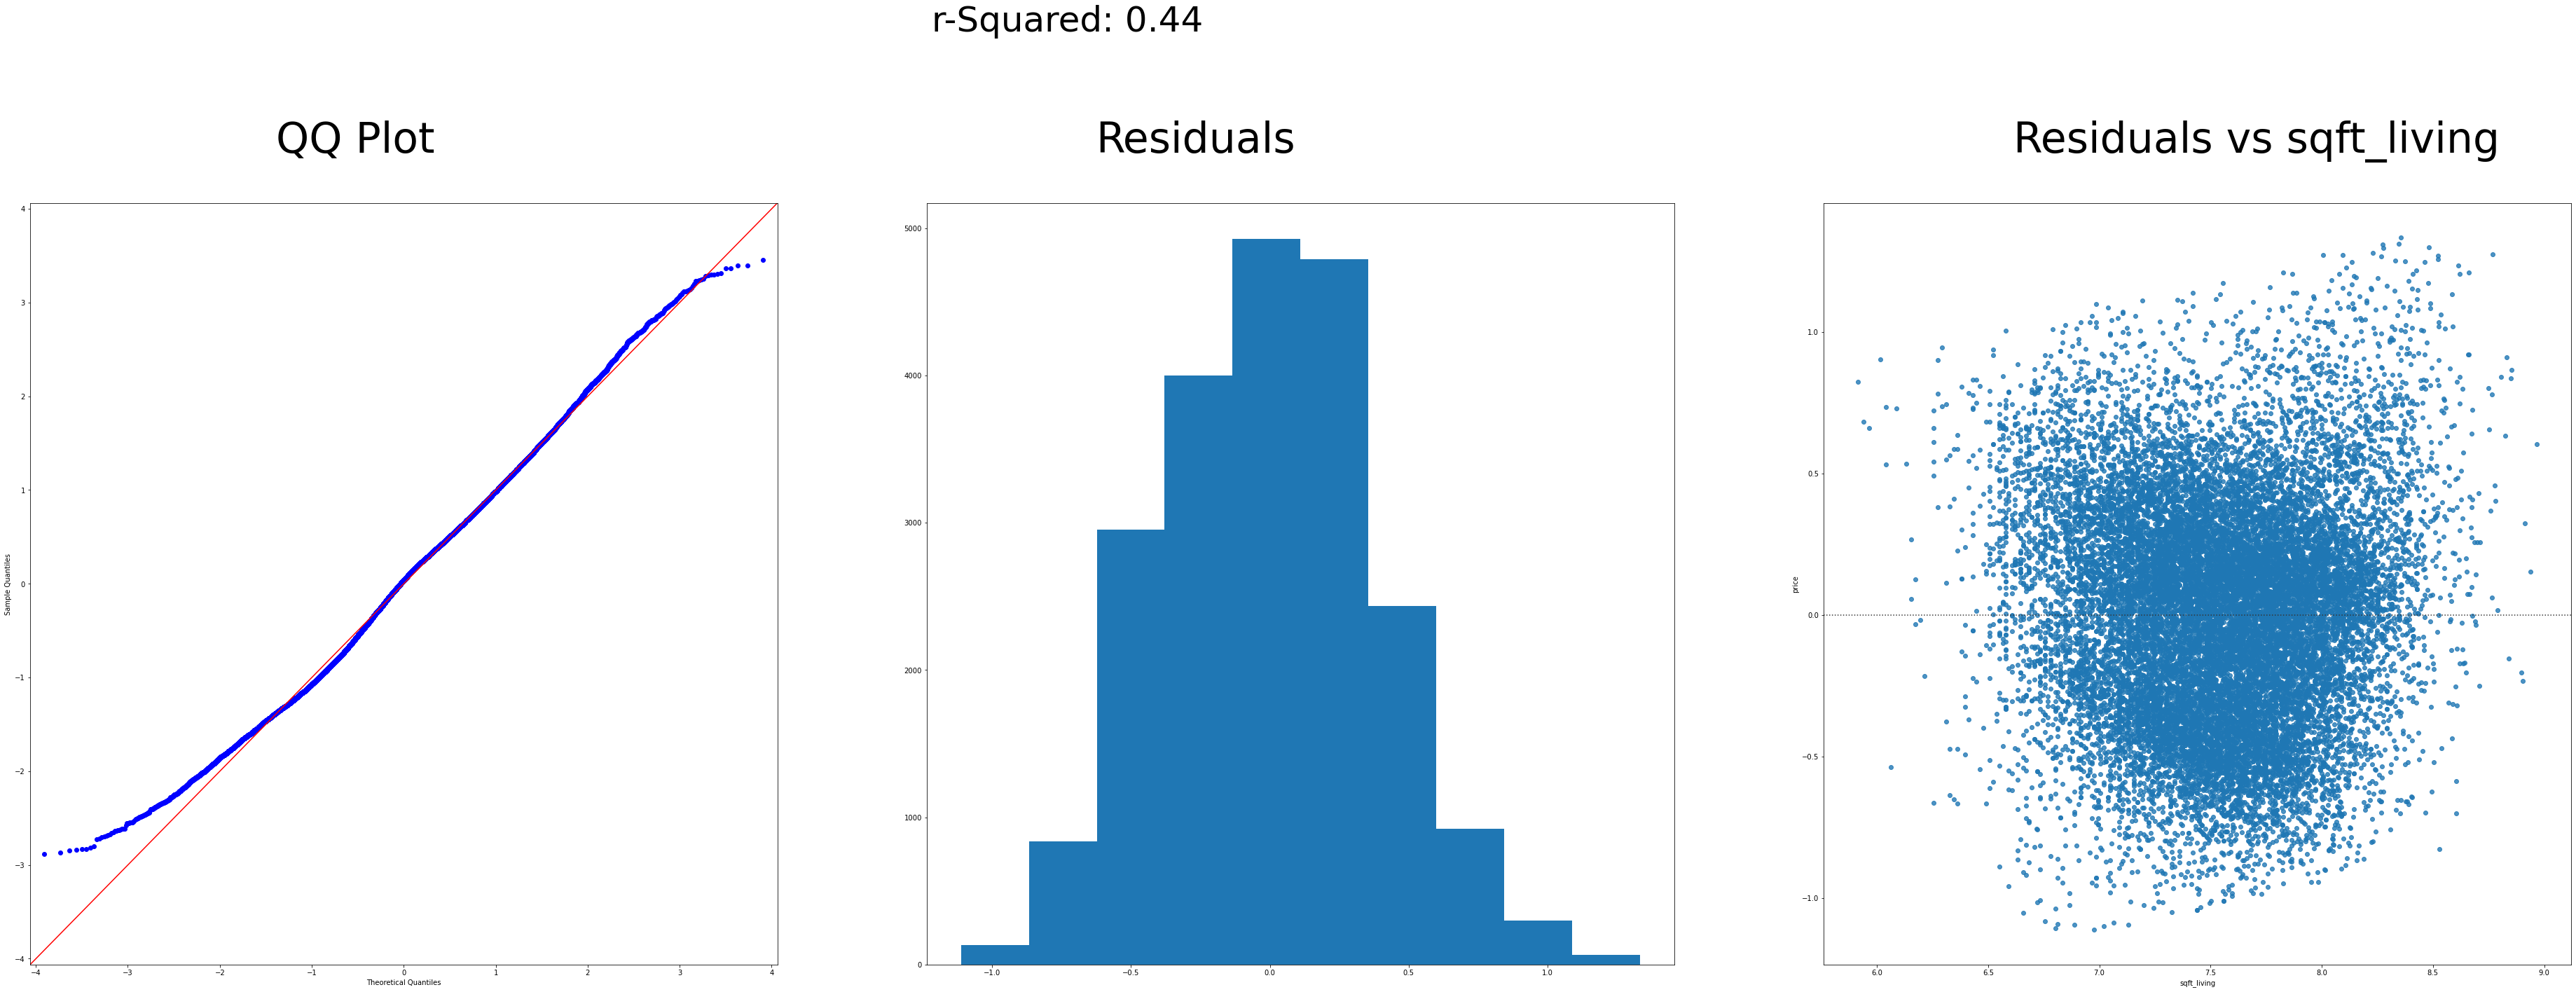

In [33]:
formula = 'price ~ sqft_living'
sqft_liv_model = smf.ols(formula = formula, data = df).fit()
model_template(sqft_liv_model, df['sqft_living'], 'sqft_living', price)

<Figure size 432x288 with 0 Axes>

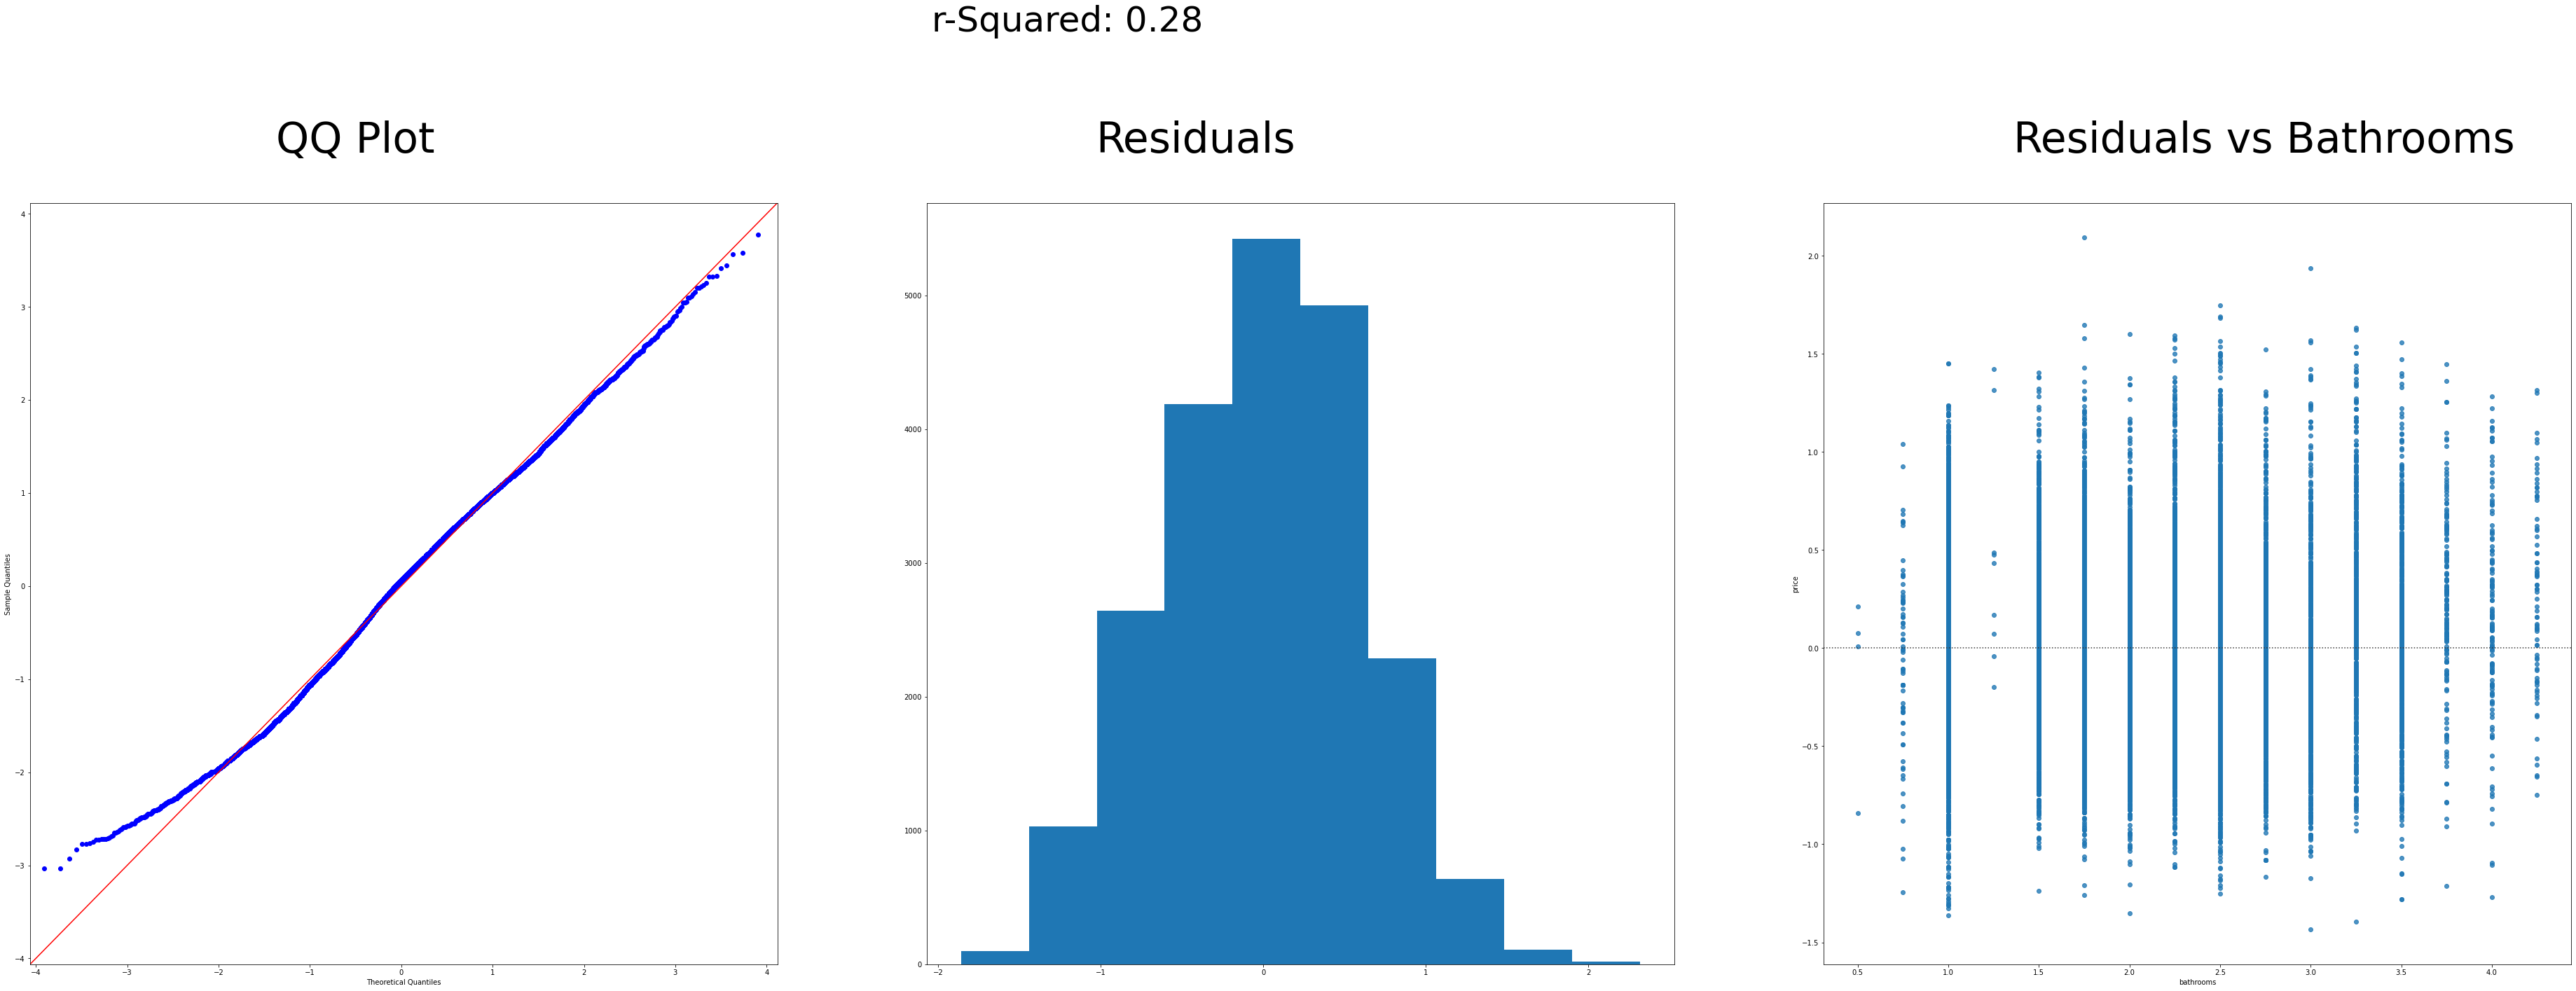

In [34]:
formula = 'bathrooms ~ price'
bath_model = smf.ols(formula=formula, data=df).fit()
model_template(bath_model, bath, 'Bathrooms', price)

<Figure size 432x288 with 0 Axes>

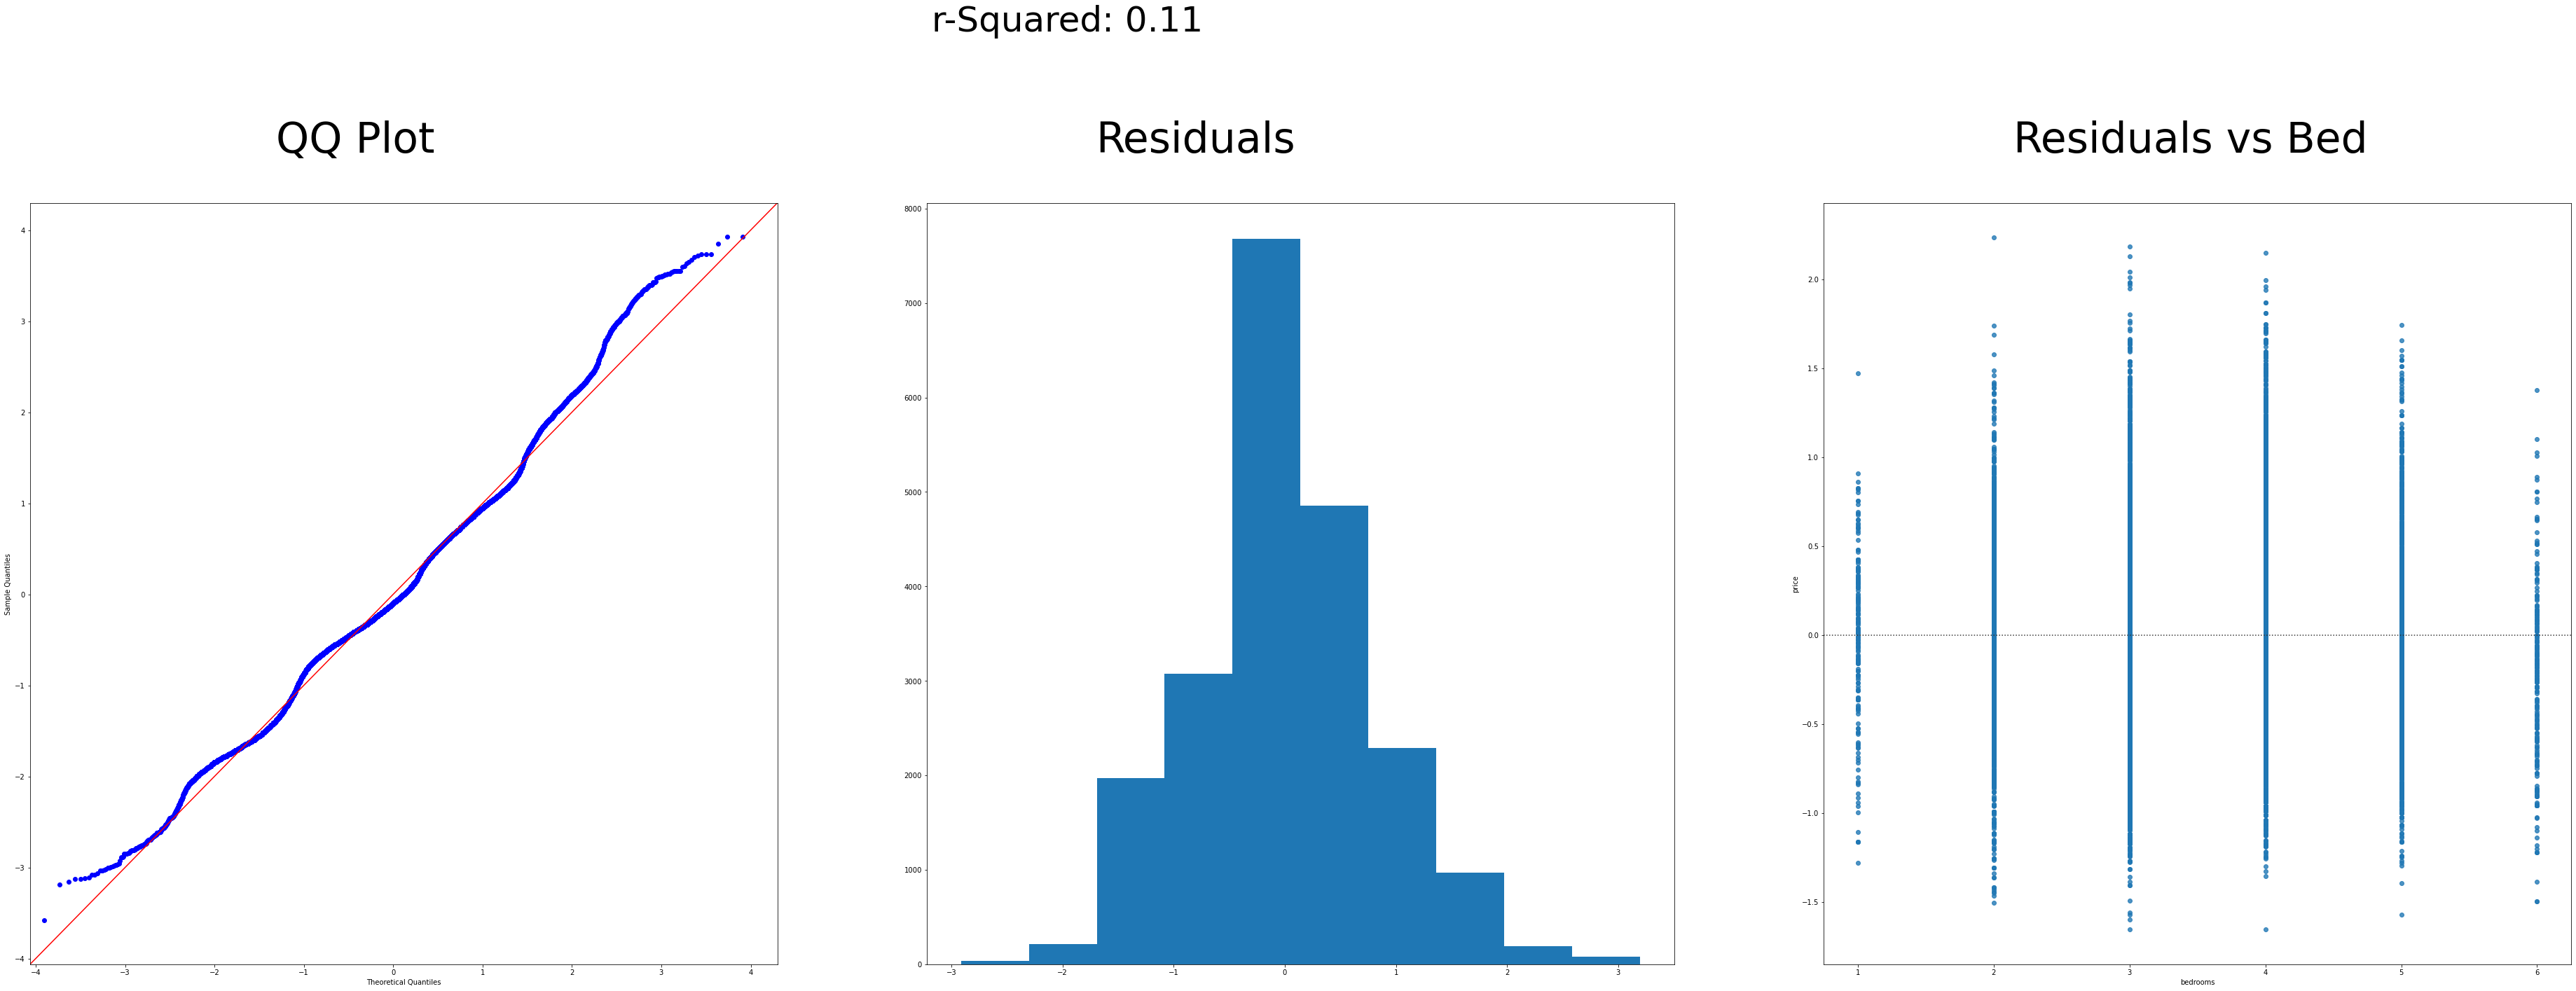

In [35]:
formula = 'bedrooms ~ price'
bed_model = smf.ols(formula=formula, data=df).fit()
model_template(bed_model, bed, 'Bed', price)

<Figure size 432x288 with 0 Axes>

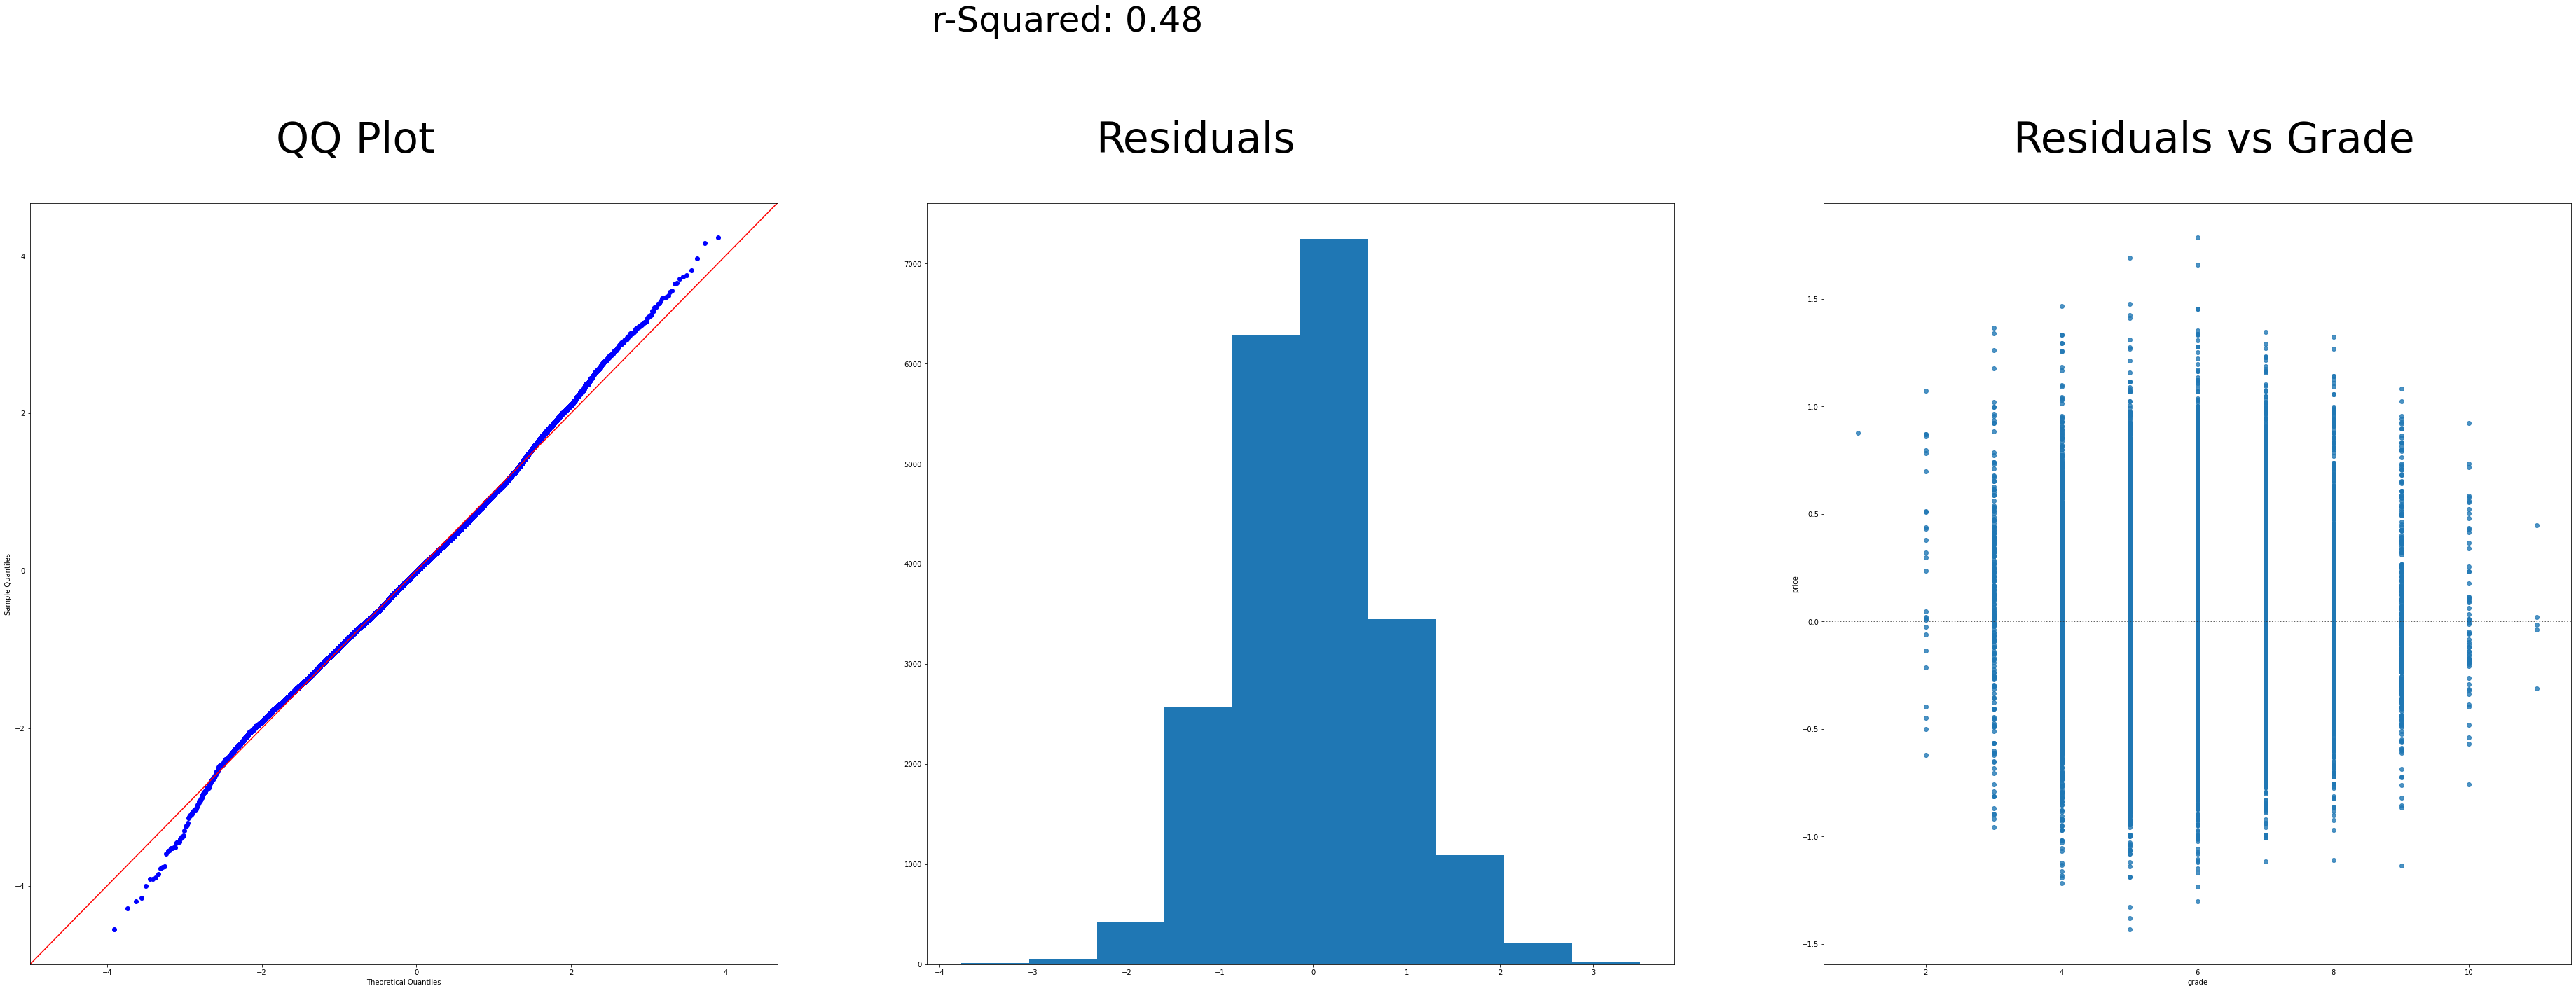

In [36]:
formula = 'grade ~ price'
grade_model = smf.ols(formula=formula, data=df).fit()
model_template(grade_model, grade, 'Grade', price)

###### The data now mostly fits for homoscedascity.  We will now create different test models to find the best fit.

In [37]:
test_model = smf.ols(formula="price ~ grade + bathrooms + sqft_living + bedrooms", data=df).fit()
test_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     6058.
Date:                Fri, 08 Apr 2022   Prob (F-statistic):               0.00
Time:                        18:56:02   Log-Likelihood:                -8013.6
No. Observations:               21363   AIC:                         1.604e+04
Df Residuals:                   21358   BIC:                         1.608e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       8.3510      0.068    122.427      0.000       8.217       8.485
grade           0.1968      0.003     60.330      0.000       0.190       0.203
bathrooms      -0.0209      0.005     -3.984      0.000      -0.031      -0.011
sqft_living     0.4964      0.012     43.097      0.000       0.474       0.519
bedrooms       -0.0364      0.004     -9.823      0.000      -0.044      -0.029
==============================================================================
Omnibus:                       89.311   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               89.602
Skew:                           0.152   Prob(JB):                     3.49e-20
Kurtosis:                       2.909   Cond. No.                         297.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
test_model_2 = smf.ols(formula="price ~ grade + bathrooms + sqft_living", data=df).fit()
test_model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     8010.
Date:                Fri, 08 Apr 2022   Prob (F-statistic):               0.00
Time:                        18:56:02   Log-Likelihood:                -8061.7
No. Observations:               21363   AIC:                         1.613e+04
Df Residuals:                   21359   BIC:                         1.616e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       8.6148      0.063    137.086      0.000       8.492       8.738
grade           0.2038      0.003     63.921      0.000       0.198       0.210
bathrooms      -0.0266      0.005     -5.106      0.000      -0.037      -0.016
sqft_living     0.4416      0.010     43.725      0.000       0.422       0.461
==============================================================================
Omnibus:                       86.164   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.616
Skew:                           0.151   Prob(JB):                     1.55e-19
Kurtosis:                       2.919   Cond. No.                         257.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
test_model_3 = smf.ols(formula="price ~ grade + bathrooms + bedrooms", data=df).fit()
test_model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     6862.
Date:                Fri, 08 Apr 2022   Prob (F-statistic):               0.00
Time:                        18:56:02   Log-Likelihood:                -8904.3
No. Observations:               21363   AIC:                         1.782e+04
Df Residuals:                   21359   BIC:                         1.785e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.2309      0.014    787.282      0.000      11.203      11.259
grade          0.2700      0.003     93.008      0.000       0.264       0.276
bathrooms      0.0711      0.005     14.257      0.000       0.061       0.081
bedrooms       0.0409      0.003     12.116      0.000       0.034       0.048
==============================================================================
Omnibus:                      122.298   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              124.268
Skew:                           0.186   Prob(JB):                     1.04e-27
Kurtosis:                       3.041   Cond. No.                         41.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
test_model_4 = smf.ols(formula="price ~ grade + sqft_living + bedrooms", data=df).fit()
test_model_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     8067.
Date:                Fri, 08 Apr 2022   Prob (F-statistic):               0.00
Time:                        18:56:02   Log-Likelihood:                -8021.5
No. Observations:               21363   AIC:                         1.605e+04
Df Residuals:                   21359   BIC:                         1.608e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       8.4718      0.061    138.609      0.000       8.352       8.592
grade           0.1936      0.003     61.190      0.000       0.187       0.200
sqft_living     0.4777      0.011     45.398      0.000       0.457       0.498
bedrooms       -0.0380      0.004    -10.331      0.000      -0.045      -0.031
==============================================================================
Omnibus:                       97.835   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               98.156
Skew:                           0.159   Prob(JB):                     4.85e-22
Kurtosis:                       2.903   Cond. No.                         260.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

###### The P values of each test are 0, so the null hypothesis can be rejected.  The model closest in R- squared value to the original model is test_model_4.  Next we will perform assumption checks on the model.

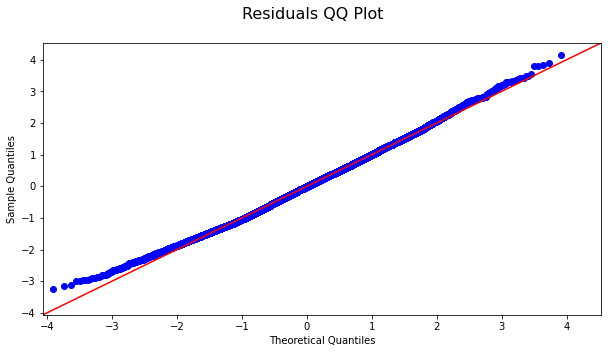

In [41]:
residuals = test_model_4.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.suptitle('Residuals QQ Plot', fontsize=16)
fig.set_size_inches(10, 5)
fig.show()

###### Most of the data follows a straight line, therefore the normality assumption is satisfied.

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, df.price)

In [43]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

In [44]:
linreg.fit(X_train, y_train)

LinearRegression()

In [45]:
y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [46]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [47]:
from sklearn.metrics import mean_squared_error

In [48]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squared Error:', train_mse)
print('Test Mean Squared Error:', test_mse)

Train Mean Squared Error: 9.40656740645032e-26
Test Mean Squared Error: 8.974167382353188e-26


###### The train and test mean squared error are very close, which means the test data fits the model well.

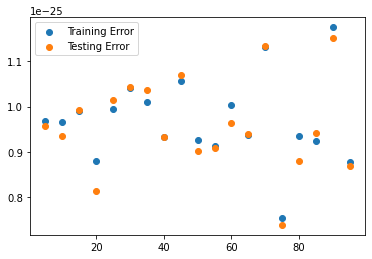

In [51]:
import random
random.seed(110)

train_err = []
test_err = []
t_sizes = list(range(5,100,5))
for t_size in t_sizes:
    X_train, X_test, y_train, y_test = train_test_split(df, df.price, test_size=t_size/100)
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_err.append(mean_squared_error(y_train, y_hat_train))
    test_err.append(mean_squared_error(y_test, y_hat_test))
plt.scatter(t_sizes, train_err, label='Training Error')
plt.scatter(t_sizes, test_err, label='Testing Error')
plt.legend();

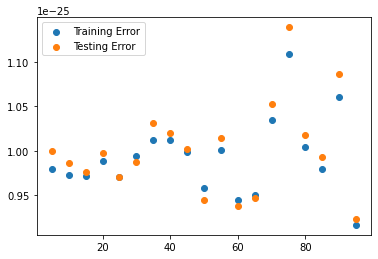

In [52]:
random.seed(900)

train_err = []
test_err = []
t_sizes = range(5,100,5)
for t_size in t_sizes:
    temp_train_err = []
    temp_test_err = []
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(df, df.price, test_size=t_size/100)
        linreg.fit(X_train, y_train)
        y_hat_train = linreg.predict(X_train)
        y_hat_test = linreg.predict(X_test)
        temp_train_err.append(mean_squared_error(y_train, y_hat_train))
        temp_test_err.append(mean_squared_error(y_test, y_hat_test))
    train_err.append(np.mean(temp_train_err))
    test_err.append(np.mean(temp_test_err))
plt.scatter(t_sizes, train_err, label='Training Error')
plt.scatter(t_sizes, test_err, label='Testing Error')
plt.legend();

###### As you can see, the test data fits the model pretty closely.  

#### In conclusion, the best approaches involve renovating or upgrading the square footage of living area, adding bedrooms, and repairing the houses in general.  Homeowners should first consider expanding living areas, then adding bedrooms, and then focus on repairs.  

###### The model does have limitations.  First, the data was logarithmically changed, meaning any new data would have to be prepared in the same manner.  It also does not take into account any extreme pricing, as outliers were removed.    

###### Further research should be undertaken to determine value increases in zipcodes, as well as outside factors such as crime rates, and accessibility to amenities.

#### Citations:
###### https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.pyplot.text.html - General text information on layout of graphs
###### https://matplotlib.org/2.0.1/api/colors_api.html -  General information on color coding graphs
###### https://stackoverflow.com/questions/13865596/quantile-quantile-plot-using-scipy - Information on graphing QQ plots
